
TODO.  Udate the wording here

# Matrix Multiplication
In this tutorial, you will write a very short high-performance FP16 matrix multiplication kernel that achieves
performance on par with cuBLAS or rocBLAS.

You will specifically learn about:

* Block-level matrix multiplications.

* Multi-dimensional pointer arithmetic.

* Program re-ordering for improved L2 cache hit rate.

* Automatic performance tuning.


## Motivations

Matrix multiplications are a key building block of most modern high-performance computing systems.
They are notoriously hard to optimize, hence their implementation is generally done by
hardware vendors themselves as part of so-called "kernel libraries" (e.g., cuBLAS).
Unfortunately, these libraries are often proprietary and cannot be easily customized
to accommodate the needs of modern deep learning workloads (e.g., fused activation functions).
In this tutorial, you will learn how to implement efficient matrix multiplications by
yourself with Triton, in a way that is easy to customize and extend.

Roughly speaking, the kernel that we will write will implement the following blocked
algorithm to multiply a (M, K) by a (K, N) matrix:

```python
# Do in parallel
for m in range(0, M, BLOCK_SIZE_M):
  # Do in parallel
  for n in range(0, N, BLOCK_SIZE_N):
    acc = zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=float32)
    for k in range(0, K, BLOCK_SIZE_K):
      a = A[m : m+BLOCK_SIZE_M, k : k+BLOCK_SIZE_K]
      b = B[k : k+BLOCK_SIZE_K, n : n+BLOCK_SIZE_N]
      acc += dot(a, b)
    C[m : m+BLOCK_SIZE_M, n : n+BLOCK_SIZE_N] = acc
```
where each iteration of the doubly-nested for-loop is performed by a dedicated Triton program instance.



## Compute Kernel

The above algorithm is, actually, fairly straightforward to implement in Triton.
The main difficulty comes from the computation of the memory locations at which blocks
of :code:`A` and :code:`B` must be read in the inner loop. For that, we need
multi-dimensional pointer arithmetic.

### Pointer Arithmetic

For a row-major 2D tensor :code:`X`, the memory location of :code:`X[i, j]` is given
by :code:`&X[i, j] = X + i*stride_xi + j*stride_xj`.
Therefore, blocks of pointers for :code:`A[m : m+BLOCK_SIZE_M, k:k+BLOCK_SIZE_K]` and
:code:`B[k : k+BLOCK_SIZE_K, n : n+BLOCK_SIZE_N]` can be defined in pseudo-code as:

```python
&A[m : m+BLOCK_SIZE_M, k:k+BLOCK_SIZE_K] =  a_ptr + (m : m+BLOCK_SIZE_M)[:, None]*A.stride(0) + (k : k+BLOCK_SIZE_K)[None, :]*A.stride(1);
&B[k : k+BLOCK_SIZE_K, n:n+BLOCK_SIZE_N] =  b_ptr + (k : k+BLOCK_SIZE_K)[:, None]*B.stride(0) + (n : n+BLOCK_SIZE_N)[None, :]*B.stride(1);
```
Which means that pointers for blocks of A and B can be initialized (i.e., :code:`k=0`) in Triton as the following
code. Also note that we need an extra modulo to handle the case where :code:`M` is not a multiple of
:code:`BLOCK_SIZE_M` or :code:`N` is not a multiple of :code:`BLOCK_SIZE_N`, in which case we can pad the data with
some useless values, which will not contribute to the results. For the :code:`K` dimension, we will handle that later
using masking load semantics.

```python
offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
offs_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
offs_k = tl.arange(0, BLOCK_SIZE_K)
a_ptrs = a_ptr + (offs_am[:, None]*stride_am + offs_k [None, :]*stride_ak)
b_ptrs = b_ptr + (offs_k [:, None]*stride_bk + offs_bn[None, :]*stride_bn)
```
And then updated in the inner loop as follows:

```python
a_ptrs += BLOCK_SIZE_K * stride_ak;
b_ptrs += BLOCK_SIZE_K * stride_bk;
```
### L2 Cache Optimizations

As mentioned above, each program instance computes a :code:`[BLOCK_SIZE_M, BLOCK_SIZE_N]`
block of :code:`C`.
It is important to remember that the order in which these blocks are computed does
matter, since it affects the L2 cache hit rate of our program, and unfortunately, a
simple row-major ordering

```Python
pid = tl.program_id(axis=0)
grid_n = tl.cdiv(N, BLOCK_SIZE_N)
pid_m = pid // grid_n
pid_n = pid % grid_n
```
is just not going to cut it.

One possible solution is to launch blocks in an order that promotes data reuse.
This can be done by 'super-grouping' blocks in groups of :code:`GROUP_M` rows before
switching to the next column:

```python
# Program ID
pid = tl.program_id(axis=0)
# Number of program ids along the M axis
num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
# Number of programs ids along the N axis
num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
# Number of programs in group
num_pid_in_group = GROUP_SIZE_M * num_pid_n
# Id of the group this program is in
group_id = pid // num_pid_in_group
# Row-id of the first program in the group
first_pid_m = group_id * GROUP_SIZE_M
# If `num_pid_m` isn't divisible by `GROUP_SIZE_M`, the last group is smaller
group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
# *Within groups*, programs are ordered in a column-major order
# Row-id of the program in the *launch grid*
pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
# Col-id of the program in the *launch grid*
pid_n = (pid % num_pid_in_group) // group_size_m
```
For example, in the following matmul where each matrix is 9 blocks by 9 blocks,
we can see that if we compute the output in row-major ordering, we need to load 90
blocks into SRAM to compute the first 9 output blocks, but if we do it in grouped
ordering, we only need to load 54 blocks.

  .. image:: grouped_vs_row_major_ordering.png

In practice, this can improve the performance of our matrix multiplication kernel by
more than 10\% on some hardware architecture (e.g., 220 to 245 TFLOPS on A100).




In [1]:
!python -V
!pip show torch
!pip show triton

Python 3.12.5
Name: torch
Version: 2.7.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: /workspace/lib/python3.12/site-packages
Requires: filelock, fsspec, jinja2, networkx, nvidia-cublas-cu12, nvidia-cuda-cupti-cu12, nvidia-cuda-nvrtc-cu12, nvidia-cuda-runtime-cu12, nvidia-cudnn-cu12, nvidia-cufft-cu12, nvidia-cufile-cu12, nvidia-curand-cu12, nvidia-cusolver-cu12, nvidia-cusparse-cu12, nvidia-cusparselt-cu12, nvidia-nccl-cu12, nvidia-nvjitlink-cu12, nvidia-nvtx-cu12, setuptools, sympy, triton, typing-extensions
Required-by: 
Name: triton
Version: 3.3.0
Summary: A language and compiler for custom Deep Learning operations
Home-page: https://github.com/triton-lang/triton/
Author: Philippe Tillet
Author-email: phil@openai.com
License: 
Location: /workspace/lib/python3.12/site-packages
Requires: setuptools
Required-by: torch


## Final Result



In [2]:
import os

#os.environ["TORCH_LOGS"] = "output_code"

import torch
import triton
import triton.language as tl
import torch.nn.functional as F


DEVICE = triton.runtime.driver.active.get_active_torch_device()


def is_cuda():
    return triton.runtime.driver.active.get_current_target().backend == "cuda"


def is_hip_cdna2():
    target = triton.runtime.driver.active.get_current_target()
    return target.backend == 'hip' and target.arch == 'gfx90a'

def get_cuda_autotune_config():
    return [
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=3,
                      num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5,
                      num_warps=2),
        triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5,
                      num_warps=2),
        # Good config for fp8 inputs.
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=3,
                      num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=3,
                      num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
# some new configs to try out
        triton.Config({'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=2,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=3,
                      num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=3,
                      num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=3,
                      num_warps=8),
# end of new configs
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4)
    ]


def get_hip_autotune_config():
    return [
        triton.Config(
            {'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 16, 'GROUP_SIZE_M': 1, 'waves_per_eu': 2},
            num_warps=4, num_stages=2),
        triton.Config(
            {'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 16, 'GROUP_SIZE_M': 4, 'waves_per_eu': 2},
            num_warps=8, num_stages=2),
        triton.Config(
            {'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 1, 'waves_per_eu': 2},
            num_warps=8, num_stages=2),
        triton.Config(
            {'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8, 'waves_per_eu': 3},
            num_warps=4, num_stages=2),
        triton.Config(
            {'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 1, 'waves_per_eu': 8},
            num_warps=4, num_stages=2),
    ]


def get_autotune_config():
    if is_cuda():
        return get_cuda_autotune_config()
    else:
        return get_hip_autotune_config()


# `triton.jit`'ed functions can be auto-tuned by using the `triton.autotune` decorator, which consumes:
#   - A list of `triton.Config` objects that define different configurations of
#       meta-parameters (e.g., `BLOCK_SIZE_M`) and compilation options (e.g., `num_warps`) to try
#   - An auto-tuning *key* whose change in values will trigger evaluation of all the
#       provided configs
@triton.autotune(
    configs=get_autotune_config(),
    key=['M', 'N', 'K'],
)
@triton.jit
def matmul_kernel(
        # Pointers to matrices
        a_ptr, b_ptr, c_ptr,
        # Matrix dimensions
        M, N, K,
        # The stride variables represent how much to increase the ptr by when moving by 1
        # element in a particular dimension. E.g. `stride_am` is how much to increase `a_ptr`
        # by to get the element one row down (A has M rows).
        stride_am, stride_ak,  #
        stride_bk, stride_bn,  #
        stride_cm, stride_cn,
        # ptr to store tile max values
        max_ptr,
        # Meta-parameters
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,  #
        GROUP_SIZE_M: tl.constexpr,  #
        ACTIVATION: tl.constexpr  #
):
    """Kernel for computing the matmul C = A x B.
    A has shape (M, K), B has shape (K, N) and C has shape (M, N)
    """
    # -----------------------------------------------------------
    # Map program ids `pid` to the block of C it should compute.
    # This is done in a grouped ordering to promote L2 data reuse.
    # See above `L2 Cache Optimizations` section for details.
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    # ----------------------------------------------------------
    # Create pointers for the first blocks of A and B.
    # We will advance this pointer as we move in the K direction
    # and accumulate
    # `a_ptrs` is a block of [BLOCK_SIZE_M, BLOCK_SIZE_K] pointers
    # `b_ptrs` is a block of [BLOCK_SIZE_K, BLOCK_SIZE_N] pointers
    # See above `Pointer Arithmetic` section for details
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

    # -----------------------------------------------------------
    # Iterate to compute a block of the C matrix.
    # We accumulate into a `[BLOCK_SIZE_M, BLOCK_SIZE_N]` block
    # of fp32 values for higher accuracy.
    # `accumulator` will be converted back to fp16 after the loop.
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        # Load the next block of A and B, generate a mask by checking the K dimension.
        # If it is out of bounds, set it to 0.
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)
        b = tl.load(b_ptrs, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0.0)
        # We accumulate along the K dimension.
        accumulator = tl.dot(a, b, accumulator)
        # accumulator = tl.ops(a, b, accumulator)
        # Advance the ptrs to the next K block.
        a_ptrs += BLOCK_SIZE_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * stride_bk
    # You can fuse arbitrary activation functions here
    # while the accumulator is still in FP32!
    if ACTIVATION == "leaky_relu":
        accumulator = leaky_relu(accumulator)

#    c = accumulator.to(tl.float16)

    tile_max = tl.max(accumulator)

    # -----------------------------------------------------------
    # Write back the block of the output matrix C with masks.
    # Change: This time we are NOT writing back the result matrix, we only care about the max
#    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
#    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
#    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
#    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
#    tl.store(c_ptrs, c, mask=c_mask)

    # write back only the max, not c
    out_index = pid_m * tl.cdiv(N, BLOCK_SIZE_N) + pid_n
    tl.store(max_ptr + out_index, tile_max.to(tl.float16))

# We can fuse `leaky_relu` by providing it as an `ACTIVATION` meta-parameter in `matmul_kernel`.
@triton.jit
def leaky_relu(x):
    return tl.where(x >= 0, x, 0.01 * x)

We can now create a convenience wrapper function that only takes two input tensors,
and (1) checks any shape constraint; (2) allocates the output; (3) launches the above kernel.



In [3]:
def matmul(a, b, activation=""):
    # Check constraints.
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"
    M, K = a.shape
    K, N = b.shape
    # Allocates output.
    c = torch.empty((M, N), device=a.device, dtype=torch.float16)
    # allocate tile maxes
    max_tiles = torch.zeros(((M*N) // 1024), device=a.device, dtype=torch.float16)
    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']), )
    matmul_kernel[grid](
        a, b, c,  #
        M, N, K,  #
        a.stride(0), a.stride(1),  #
        b.stride(0), b.stride(1),  #
        c.stride(0), c.stride(1),  #
        max_ptr = max_tiles,
        ACTIVATION=activation  #
    )
    c_max = max_tiles.max()
    # We only care about returning the max 
    return c_max

In [4]:
#def matmul_ops(a, b, activation=""):
#    c = trio.matmul(a,b)
#    if ACTIVATION == "leaky_relu":
#        c = leaky_relu(c)
#    return c

In [5]:
def my_torch_matmul_relu(a, b):
    c = torch.matmul(a, b)
    c = F.leaky_relu(c, negative_slope=0.01)
    c_max = torch.max(c)
    return c_max

In [6]:
@torch.compile
def my_torch_matmul_relu_compiled(a, b):
    c = torch.matmul(a, b)
    c = F.leaky_relu(c, negative_slope=0.01)
    c_max = torch.max(c)
    return c_max

In [7]:
torch._dynamo.config.recompile_limit = 9001           # Needed for certain torch.compile configs

@torch.compile(dynamic=False)
def my_torch_matmul_relu_compiled_no_dynamic(a, b):
    c = torch.matmul(a, b)
    c = F.leaky_relu(c, negative_slope=0.01)
    c_max = torch.max(c)
    return c_max

In [8]:
#@torch.compile(mode="max-autotune-no-cudagraphs")
#def my_torch_matmul_relu_compiled_maxauto_nocudagraphs(a, b):
#    c = torch.matmul(a, b)
#    c = F.leaky_relu(c, negative_slope=0.01)
#    c_max = torch.max(c)
#    return c_max

In [9]:
# For profiling
torch.manual_seed(0)
a = torch.randn((2048, 2048), device=DEVICE, dtype=torch.float16)
b = torch.randn((2048, 2048), device=DEVICE, dtype=torch.float16)

In [10]:
triton_max = matmul(a, b, "leaky_relu")

In [11]:
torch_max = my_torch_matmul_relu(a, b)

## Unit Test

We can test our custom matrix multiplication operation against a native torch implementation (i.e., cuBLAS).



In [12]:
torch.manual_seed(0)
a = torch.randn((512, 512), device=DEVICE, dtype=torch.float16)
b = torch.randn((512, 512), device=DEVICE, dtype=torch.float16)
#triton_output = matmul(a, b)
triton_max = matmul(a, b, "leaky_relu")
torch_max = my_torch_matmul_relu_compiled(a, b)
print(f"triton_max_with_fp16_inputs={triton_max}")
print(f"torch_max_with_fp16_inputs={torch_max}")
# Bigger tolerance for AMD CDNA2 devices.
# CDNA2 devices use reduced precision fp16 and bf16 and flush input and
# output denormal values to zero. Detailed info is at: https://pytorch.org/docs/stable/notes/numerical_accuracy.html#reduced-precision-fp16-and-bf16-gemms-and-convolutions-on-amd-instinct-mi200-devices
rtol = 1e-2 if is_hip_cdna2() else 0
if torch.allclose(triton_max, torch_max, atol=0.125, rtol=rtol):
    print("✅ Triton and Torch result max match")
else:
    print("❌ Triton and Torch result max differ")

TORCH_HAS_FP8 = hasattr(torch, "float8_e5m2")
if TORCH_HAS_FP8 and is_cuda():
    torch.manual_seed(0)
    a = torch.randn((512, 512), device=DEVICE, dtype=torch.float16)
    b = torch.randn((512, 512), device=DEVICE, dtype=torch.float16)
    a = a.to(torch.float8_e5m2)
    # pre-transpose b for efficiency.
    b = b.T
    b = b.to(torch.float8_e5m2)
    triton_max = matmul(a, b, "leaky_relu")
#    torch_output = torch.matmul(a.to(torch.float16), b.to(torch.float16))
    torch_max = my_torch_matmul_relu(a.to(torch.float16), b.to(torch.float16))
    print(f"triton_max_with_fp8_inputs={triton_max}")
    print(f"torch_max_with_fp8_inputs={torch_max}")

    if torch.allclose(triton_max, torch_max, atol=1e-2, rtol=rtol):
        print("✅ Triton and Torch result max match")
    else:
        print("❌ Triton and Torch result max differ")

    

triton_max_with_fp16_inputs=107.9375
torch_max_with_fp16_inputs=107.9375
✅ Triton and Torch result max match
triton_max_with_fp8_inputs=98.75
torch_max_with_fp8_inputs=98.75
✅ Triton and Torch result max match


## Benchmark

### Square Matrix Performance

We can now compare the performance of our kernel against that of cuBLAS or rocBLAS. Here we focus on square matrices,
but feel free to arrange this script as you wish to benchmark any other matrix shape.



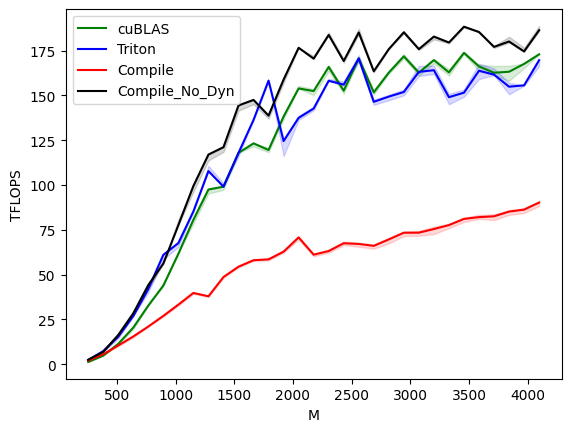

matmul-performance-fp16:
         M       N       K      cuBLAS      Triton    Compile  Compile_No_Dyn
0    256.0   256.0   256.0    1.310720    2.340571   2.048000        2.520615
1    384.0   384.0   384.0    4.808348    7.372800   5.529600        6.912000
2    512.0   512.0   512.0   11.397565   15.420235  10.485760       16.384000
3    640.0   640.0   640.0   20.480001   26.947370  15.515151       28.444443
4    768.0   768.0   768.0   32.768000   42.130286  21.065143       44.236801
5    896.0   896.0   896.0   43.904000   61.083825  27.017846       56.197121
6   1024.0  1024.0  1024.0   61.680940   67.650065  33.288127       77.672296
7   1152.0  1152.0  1152.0   80.702267   85.313826  39.813118       99.532803
8   1280.0  1280.0  1280.0   97.523810  107.789478  37.925926      117.028568
9   1408.0  1408.0  1408.0   99.123199   99.123199  48.676571      121.150576
10  1536.0  1536.0  1536.0  117.964803  117.964803  54.445292      144.446699
11  1664.0  1664.0  1664.0  123.272762 

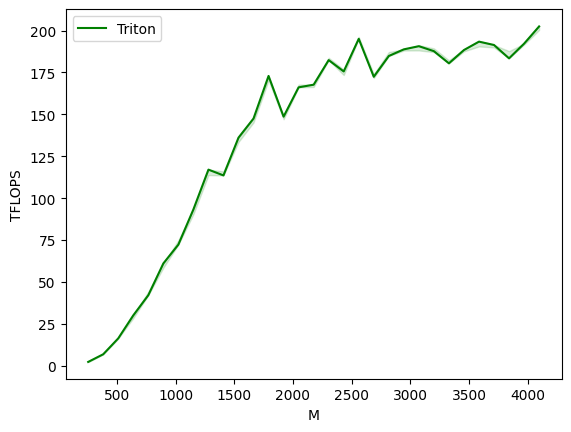

matmul-performance-fp8:
         M       N       K      Triton
0    256.0   256.0   256.0    2.340571
1    384.0   384.0   384.0    6.912000
2    512.0   512.0   512.0   16.384000
3    640.0   640.0   640.0   30.117647
4    768.0   768.0   768.0   42.130286
5    896.0   896.0   896.0   61.083825
6   1024.0  1024.0  1024.0   72.315584
7   1152.0  1152.0  1152.0   93.312000
8   1280.0  1280.0  1280.0  117.028568
9   1408.0  1408.0  1408.0  113.578663
10  1536.0  1536.0  1536.0  136.113232
11  1664.0  1664.0  1664.0  147.523150
12  1792.0  1792.0  1792.0  172.914215
13  1920.0  1920.0  1920.0  148.645157
14  2048.0  2048.0  2048.0  166.111053
15  2176.0  2176.0  2176.0  167.697071
16  2304.0  2304.0  2304.0  182.350177
17  2432.0  2432.0  2432.0  175.590404
18  2560.0  2560.0  2560.0  195.047621
19  2688.0  2688.0  2688.0  172.422980
20  2816.0  2816.0  2816.0  184.805961
21  2944.0  2944.0  2944.0  188.772847
22  3072.0  3072.0  3072.0  190.650187
23  3200.0  3200.0  3200.0  187.683281
2

In [14]:
ref_lib = 'cuBLAS' if is_cuda() else 'rocBLAS'

configs = []
for fp8_inputs in [False, True]:
    if fp8_inputs and (not TORCH_HAS_FP8 or not is_cuda()):
        continue
    configs.append(
        triton.testing.Benchmark(
            x_names=["M", "N", "K"],  # Argument names to use as an x-axis for the plot
            x_vals=[128 * i for i in range(2,33)],  # Different possible values for `x_name`
            line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
            # Possible values for `line_arg`
            # Don't compare to cublas for fp8 cases as torch.matmul doesn't support fp8 at the moment.
            line_vals=["triton"] if fp8_inputs else [ref_lib.lower(), "triton", "compile", "compile_no_dynamic"],  # Label name for the lines
            line_names=["Triton"] if fp8_inputs else [ref_lib, "Triton", "Compile", "Compile_No_Dyn"],  # Line styles
            styles=[("green", "-"), ("blue", "-"), ("red", "-"), ("black", "-")],
            ylabel="TFLOPS",  # Label name for the y-axis
            plot_name="matmul-performance-" +
            ("fp16" if not fp8_inputs else "fp8"),  # Name for the plot, used also as a file name for saving the plot.
            args={"fp8_inputs": fp8_inputs},
        ))


@triton.testing.perf_report(configs)
def benchmark(M, N, K, provider, fp8_inputs):
    a = torch.randn((M, K), device=DEVICE, dtype=torch.float16)
    b = torch.randn((K, N), device=DEVICE, dtype=torch.float16)
    if TORCH_HAS_FP8 and fp8_inputs:
        a = a.to(torch.float8_e5m2)
        b = b.T
        b = b.to(torch.float8_e5m2)
    quantiles = [0.5, 0.2, 0.8]
    if provider == ref_lib.lower():
#        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(a, b), quantiles=quantiles)
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: my_torch_matmul_relu(a, b), quantiles=quantiles)
    if provider == 'triton':
#        ms, min_ms, max_ms = triton.testing.do_bench(lambda: matmul(a, b), quantiles=quantiles)
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: matmul(a, b, "leaky_relu"), quantiles=quantiles)
    if provider == 'compile':
#        ms, min_ms, max_ms = triton.testing.do_bench(lambda: matmul(a, b), quantiles=quantiles)
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: my_torch_matmul_relu_compiled(a, b), quantiles=quantiles)
    if provider == 'compile_no_dynamic':
#        ms, min_ms, max_ms = triton.testing.do_bench(lambda: matmul(a, b), quantiles=quantiles)
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: my_torch_matmul_relu_compiled_no_dynamic(a, b), quantiles=quantiles)
    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


benchmark.run(show_plots=True, print_data=True)